In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./stock_historical_data/{}.csv".format("LT.NS"))
df.set_index("Date", inplace=True)
df["date"] = df.index

<Axes: xlabel='Close'>

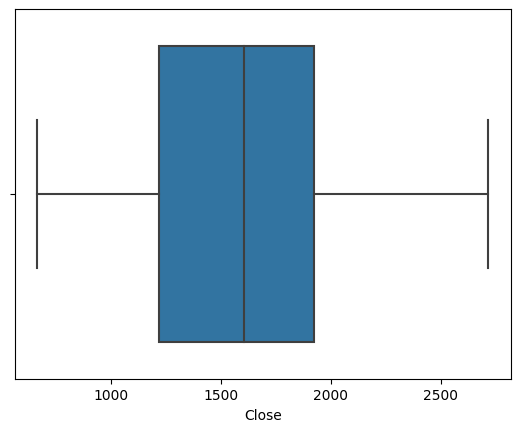

In [3]:
import seaborn as sns
sns.boxplot(x="Close",data=df)

In [4]:
isClassification = True

In [5]:
target = []
for i in range(0,len(df)):
    if df.iloc[i].Open > df.iloc[i].Close:
        target.append(0)
    else:
        target.append(1)
df["target"] = target

In [25]:
var_colums = [c for c in df.columns if c not in ['date','']]
X = df.loc[:, var_colums]
y = df.loc[:, 'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((728, 6), (182, 6), (728,), (182,))

In [32]:
y_valid.head()

Date
2022-07-01    1
2021-08-31    1
2020-05-12    0
2023-01-10    0
2023-03-17    1
Name: target, dtype: int64

In [33]:
df1 = pd.DataFrame(df.Close)
df1.reset_index(inplace=True)

In [34]:
df1 = df1.drop("Date",axis=1)
df1

,Close
0,1212.869873
1,1245.600220
2,1236.109985
3,1219.166016
4,1222.638184
...,...
905,2717.600098
906,2688.149902
907,2638.399902
908,2695.350098


In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [37]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [38]:
train_data.shape , test_data.shape

((728, 1), (182, 1))

In [50]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        if isClassification == True:
            #print("timegap",(i)  + time_step,"second",(i -20)  + time_step)
            #print(dataset[(i)  + time_step, 0])
            if (dataset[(i)  + time_step, 0] > dataset[(i -20)  + time_step, 0]):
                dataY.append(1)
            else:
                dataY.append(0)
        else:
            dataY.append(dataset[i + time_step, 0])

        #if isClassification == False:
            #dataY.append(dataset[i + time_step, 0])
        #else:
         #   dataY.append(dataset[i + time_step, 0])

    return numpy.array(dataX), numpy.array(dataY)

In [51]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [53]:
ytest

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [54]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [55]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [56]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='softmax'))  
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=1,batch_size=64,verbose=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 10s 310ms/step - loss: 0.0000e+00 - accuracy: 0.6348 - val_loss: 0.0000e+00 - val_accuracy: 0.7901


In [60]:
import tensorflow as tf

In [61]:
### Lets Do the prediction and check performance metrics
#train_predict =  model.predict(X_train)
test_predict  =  model.predict(X_test)

3/3 [==============================] - 2s 42ms/step


In [62]:
test_predict

array([[0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.999

In [63]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

NameError: name 'train_predict' is not defined

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()